# DES Y6 Deep Field Exposures:  Photometric Zeropoint Cross-Checks (QA)

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import glob
import math
import os
import subprocess
import sys
import gc

import glob

import fitsio
from astropy.io import fits
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack

import tempfile

import matplotlib.pyplot as plt
 
%matplotlib inline

In [2]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## 2. User Input

### 2.1.  General User Input  

In [3]:
verbose = 1
tag_des = 'Y6A2_FINALCUT'      # Official tag for DES Y6A2_FINALCUT
tag_decade = 'DECADE_FINALCUT' # Tag for DECADE
rawdata_dir = '../RawData'
zeropoints_dir='../Zeropoints'
qa_dir = '../QA'
qaFileBaseName = 'qaPlot.ZPs'
bandList = ['g', 'r', 'i', 'z']

### 2.2. Logical Variables to Indicate which Code Cells to Run

In [4]:
do_qa_zp_xchecks = True

### 2.3. Check on Location of TMPDIR...

In [5]:
# Check on TMPDIR... 
tempfile.gettempdir()

'/data/des40.a/data/dtucker/TmpDir'

In [6]:
# Set tmpdir variable to $TMPDIR (for future reference)...
tmpdir = os.environ['TMPDIR']

### 2.4. Create Main QA Directory (if it does not already exist)...

In [7]:
# Create main QA directory, if it does not already exist...
if not os.path.exists(qa_dir):
    os.makedirs(qa_dir)

## 3. Useful Modules

In [8]:
# Robust Standard Deviation (from Zeljko Ivezic)...
def RSD(arr):
    return 0.741*(np.quantile(arr, 0.75)-np.quantile(arr, 0.25))

In [9]:
def readZPFiles(subdir, zptype, bandList):

    df_zp_collection = {}

    for band in bandList:
        
        zpFile = """zps_%s.%s.%s.csv""" % (subdir, band, zptype)
        zpFile = os.path.join(zeropoints_dir, zpFile)
        df_zp = pd.read_csv(zpFile, usecols=['FILENAME','EXPNUM_MEDIAN','CCDNUM_MEDIAN',
                                         'MAG_ZERO_MEAN','MAG_ZERO_MEAN_ERR','MAG_ZERO_NUM',
                                         'AIRMASS_MEDIAN','EXPTIME_MEDIAN',
                                         'RA_CENT_MEDIAN','DEC_CENT_MEDIAN','MJD_OBS_MEDIAN'])

        # Rename '_MEDIAN' columns...
        #  (The '_MEDIAN' suffix is a 'feature' of how the zeropoints table was created.)
        df_zp.rename(columns={'EXPNUM_MEDIAN':'EXPNUM',
                              'CCDNUM_MEDIAN':'CCDNUM',
                              'AIRMASS_MEDIAN':'AIRMASS', 
                              'EXPTIME_MEDIAN':'EXPTIME', 
                              'RA_CENT_MEDIAN':'RA_CENT', 
                              'DEC_CENT_MEDIAN':'DEC_CENT',
                              'MJD_OBS_MEDIAN':'MJD_OBS'
                            },inplace=True)

        # Likewise, convert EXPNUM, CCDNUM, and MAG_ZERO_NUM from floats to ints...
        #  (Again, a 'feature' of how the zeropoints table was created.)
        df_zp['EXPNUM'] = df_zp['EXPNUM'].astype(int)
        df_zp['CCDNUM'] = df_zp['CCDNUM'].astype(int)
        df_zp['MAG_ZERO_NUM'] = df_zp['MAG_ZERO_NUM'].astype(int)

        # Add a exptime-scaled versions of MAG_ZERO_MEAN...
        df_zp['MAG_ZERO_MEAN_SCALED'] = df_zp['MAG_ZERO_MEAN'] - 2.5*np.log10(df_zp['EXPTIME'])

        # Add df_zp the df_zp_collection_des dictionary...
        df_zp_collection[band] = df_zp

    return df_zp_collection

In [10]:
def xcheckQAPlots(df_zp_collection, df_zp_des_y6a2, bandList, supertitle, outputFileName):

    # Prepare QA plots...
    fig = plt.figure(figsize=(20,10))
    #fig = plt.figure(figsize=(20,5))
    #fig.subplots_adjust(hspace=0.3)
    #fig.subplots_adjust(hspace=0.5)
    #fig.tight_layout()
    #fig.subplots_adjust(top=0.88)  # Use if doing fig.tight_layout()
    #fig.suptitle(supertitle, y = 1.10, fontsize=28, fontweight='bold')
    #fig.suptitle(supertitle, y = 1.05, fontsize=28, fontweight='bold')
    fig.suptitle(supertitle, fontsize=28, fontweight='bold')
    plt.rcParams.update({'font.size': 14})
    cmap_scale = 'rainbow'

    i = 1
    for band in bandList:
        
        df_zp_band = df_zp_collection[band]

        # To drop columns with duplicate names, we make use of 
        #  recommendations from an e-mail from S. Allam (27 July 2016)
        #  and from these two stackoverflow questions:
        #  http://stackoverflow.com/questions/27313647/merging-two-pandas-dataframes-results-in-duplicate-columns 
        #  and http://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns
        # First try to match FILENAME against CATALOGNAME.  If that fails (e.g., for DECADE), then
        #  try to match [EXPNUM,CCDNUM] against [EXPNUM,CCDNUM]...
        df_zp_merged = pd.merge(df_zp_des_y6a2, df_zp_band, left_on='CATALOGNAME', right_on='FILENAME', suffixes=('', '_y'))
        if df_zp_merged.CATALOGNAME.size <= 0:
            #df_zp_merged = pd.merge(df_zp_des_y6a2, df_zp_band, left_on=['EXPNUM', 'CCDNUM'], right_on=['EXPNUM', 'CCDNUM'], suffixes=('', '_y'))
            df_zp_merged = pd.merge(df_zp_des_y6a2, df_zp_band, on=['EXPNUM', 'CCDNUM'], suffixes=('', '_y'))
        to_drop = [colname for colname in df_zp_merged if colname.endswith('_y')]
        df_zp_merged.drop(to_drop, axis=1, inplace=True)
        
        # Add a DELTA_ZP column...
        df_zp_merged['DELTA_ZP'] = (df_zp_merged['MAG_ZERO_MEAN'] - df_zp_merged['MAG_ZERO'])

        # Mask out extreme outliers (for plots)...
        mask =  ( (df_zp_merged['MAG_ZERO_MEAN_SCALED'] >= 10.)  & (df_zp_merged['MAG_ZERO_MEAN_SCALED'] < 40.) )
        mask &= ( (df_zp_merged['AIRMASS'] >= 0.)  & (df_zp_merged['AIRMASS'] < 5.) )
        mask &= ( (~df_zp_merged['MAG_ZERO_MEAN_ERR'].isnull()) & (df_zp_merged['MAG_ZERO_MEAN_ERR'] < 0.05) )
        mask &= (df_zp_merged['MAG_ZERO_NUM'] >= 1) 
        mask &= (np.abs(df_zp_merged['DELTA_ZP']) <= 0.1)

        # For simplicity, use "df1" for the masked "df_zp_band"...
        df1 = df_zp_merged[mask]

        delta_zp_desc = df1['DELTA_ZP'].describe(percentiles=[0.001, 0.01, 0.25, 0.5, 0.75, 0.99, 0.999])
        #print delta_zp_desc
        mask &= ((df_zp_merged['DELTA_ZP'] >= delta_zp_desc['0.1%']) & \
                 (df_zp_merged['DELTA_ZP'] <= delta_zp_desc['99.9%']))
        df1 = df_zp_merged[mask]
    
        if df1['DELTA_ZP'].size > 0:    
            plt.subplot(2,4,i)
            plt.axis('on')
            plotText = """%s-band\nmedian=%.4f\nstddev=%.4f""" % (band, delta_zp_desc['50%'], 0.741*(delta_zp_desc['75%']-delta_zp_desc['25%']))
            plt.hist(df1.DELTA_ZP, bins=100, color='grey', alpha=0.2, log=False)
            #plt.xlim([delta_zp_desc['0.1%'], delta_zp_desc['99.9%']])
            plt.xlim([-0.05, 0.05])
            #plt.legend(fontsize=12, framealpha=0.5)
            plt.grid(True)
            plt.axvline(delta_zp_desc['50%'], color='k', linestyle='dashed', linewidth=1)
            min_ylim, max_ylim = plt.ylim()
            plt.text(-0.045, max_ylim*0.8, plotText)
            #plt.text(delta_zp_desc['50%']*1.1, max_ylim*0.9, 'Median: {:.4f}'.format(delta_zp_desc['50%'])
            plt.xlabel('DELTA_ZP [mag]')
            plt.ylabel('Number')
        else:
            plt.subplot(2,4,i)
            plotText = """No plot for\n%s-band""" % (band) 
            plt.text(0.1,0.5,plotText, ha='center')
            plt.axis('off')

        if df1['DELTA_ZP'].size > 0:    
            plt.subplot(2,4,4+i)
            plt.axis('on')
            plotText = """%s-band""" % (band)
            plt.scatter(df1.MJD_OBS, 
                        df1.DELTA_ZP, 
                        c=df1.CCDNUM, cmap=cmap_scale, label=plotText, alpha=0.1)
#                        color='blue', label=plotText, alpha=0.1)
            plt.colorbar(label='CCDNUM')
            plt.legend(framealpha=0.5)
            plt.xlabel('MJD [days]')
            plt.ylabel('DELTA_ZP [mag]')
            plt.ylim([-0.10, 0.10])
            plt.grid(True)            
        else:
            plt.subplot(2,4,4+i)
            plotText = """No plot for\n%s-band""" % (band) 
            plt.text(0.1,0.5,plotText, ha='center')
            plt.axis('off')

        i = i + 1
                
    # Plot...
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.show()
    plt.savefig(outputFileName)    

    return 0

In [11]:
def galexGaiaEDR3vsSDSSuQAPlots(df_zp_galex_u, df_zp_sdss_u, supertitle, outputFileName):

    band = 'u'
    
    # Prepare QA plots...
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(supertitle, fontsize=28, fontweight='bold')
    plt.rcParams.update({'font.size': 14})
    cmap_scale = 'rainbow'

        
    # To drop columns with duplicate names, we make use of 
    #  recommendations from an e-mail from S. Allam (27 July 2016)
    #  and from these two stackoverflow questions:
    #  http://stackoverflow.com/questions/27313647/merging-two-pandas-dataframes-results-in-duplicate-columns 
    #  and http://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns
    # First try to match FILENAME against CATALOGNAME.  If that fails (e.g., for DECADE), then
    #  try to match [EXPNUM,CCDNUM] against [EXPNUM,CCDNUM]...
    df_zp_merged = pd.merge(df_zp_sdss_u, df_zp_galex_u, on='FILENAME', suffixes=('_SDSS', '_GALEX'))
    if df_zp_merged.FILENAME.size <= 0:
        df_zp_merged = pd.merge(df_zp_sdss_u, df_zp_galex_u, on=['EXPNUM', 'CCDNUM'], suffixes=('_SDSS', '_GALEX'))    
        
    # Add a DELTA_ZP column...
    df_zp_merged['DELTA_ZP'] = (df_zp_merged['MAG_ZERO_MEAN_GALEX'] - df_zp_merged['MAG_ZERO_MEAN_SDSS'])

    # Mask out extreme outliers (for plots)...
    mask =  ( (df_zp_merged['MAG_ZERO_MEAN_SCALED_SDSS'] >= 10.)  & (df_zp_merged['MAG_ZERO_MEAN_SCALED_SDSS'] < 40.) )
    mask &= ( (df_zp_merged['AIRMASS_SDSS'] >= 0.)  & (df_zp_merged['AIRMASS_SDSS'] < 5.) )
    mask &= ( (~df_zp_merged['MAG_ZERO_MEAN_ERR_SDSS'].isnull()) & (df_zp_merged['MAG_ZERO_MEAN_ERR_SDSS'] < 0.3) )
    mask &= (df_zp_merged['MAG_ZERO_NUM_SDSS'] >= 1) 
    mask &= ( (df_zp_merged['MAG_ZERO_MEAN_SCALED_GALEX'] >= 10.)  & (df_zp_merged['MAG_ZERO_MEAN_SCALED_GALEX'] < 40.) )
    mask &= ( (df_zp_merged['AIRMASS_GALEX'] >= 0.)  & (df_zp_merged['AIRMASS_GALEX'] < 5.) )
    mask &= ( (~df_zp_merged['MAG_ZERO_MEAN_ERR_GALEX'].isnull()) & (df_zp_merged['MAG_ZERO_MEAN_ERR_GALEX'] < 0.3) )
    mask &= (df_zp_merged['MAG_ZERO_NUM_GALEX'] >= 1) 
    #mask &= (np.abs(df_zp_merged['DELTA_ZP']) <= 1.0)

    # For simplicity, use "df1" for the masked "df_zp_band"...
    df1 = df_zp_merged[mask]

    delta_zp_desc = df1['DELTA_ZP'].describe(percentiles=[0.001, 0.01, 0.25, 0.5, 0.75, 0.99, 0.999])
    print delta_zp_desc
    mask &= ((df_zp_merged['DELTA_ZP'] >= delta_zp_desc['0.1%']) & \
             (df_zp_merged['DELTA_ZP'] <= delta_zp_desc['99.9%']))
    df1 = df_zp_merged[mask]
        
    if df1['DELTA_ZP'].size > 0:    
        plt.subplot(2,4,1)
        plt.axis('on')
        plotText = """%s-band\nmedian=%.4f\nstddev=%.4f""" % (band, delta_zp_desc['50%'], 0.741*(delta_zp_desc['75%']-delta_zp_desc['25%']))
        plt.hist(df1.DELTA_ZP, bins=25, color='grey', alpha=0.2, log=False)
        plt.xlim([delta_zp_desc['0.1%'], delta_zp_desc['99.9%']])
        #plt.xlim([-0.05, 0.05])
        plt.grid(True)
        plt.axvline(delta_zp_desc['50%'], color='k', linestyle='dashed', linewidth=1)
        min_xlim, max_xlim = plt.xlim()
        min_ylim, max_ylim = plt.ylim()
        x_text = 0.05*(max_xlim - min_xlim) + min_xlim
        y_text = 0.80*(max_ylim - min_ylim) + min_ylim
        plt.text(x_text, y_text, plotText)
        plt.xlabel('DELTA_ZP [mag]')
        plt.ylabel('Number')
    else:
        plt.subplot(2,4,1)
        plotText = """No plot for\n%s-band""" % (band) 
        plt.text(0.1,0.5,plotText, ha='center')
        plt.axis('off')

    if df1['DELTA_ZP'].size > 0:    
        plt.subplot(2,4,2)
        plt.axis('on')
        plotText = """%s-band""" % (band)
        plt.scatter(df1.MJD_OBS_SDSS, 
                    df1.DELTA_ZP, 
                    c=df1.CCDNUM_SDSS, cmap=cmap_scale, label=plotText, alpha=0.1)
        plt.colorbar(label='CCDNUM')
        plt.legend(framealpha=0.5)
        plt.xlabel('MJD [days]')
        plt.ylabel('DELTA_ZP [mag]')
        plt.ylim([delta_zp_desc['0.1%'], delta_zp_desc['99.9%']])
        #plt.ylim([-0.10, 0.10])
        plt.grid(True)            
    else:
        plt.subplot(2,4,2)
        plotText = """No plot for\n%s-band""" % (band) 
        plt.text(0.1,0.5,plotText, ha='center')
        plt.axis('off')

    if df1['DELTA_ZP'].size > 0:    
        plt.subplot(2,4,3)
        plt.axis('on')
        plotText = """%s-band""" % (band)
        plt.scatter(df1.RA_CENT_SDSS, 
                    df1.DELTA_ZP, 
                    c=df1.CCDNUM_SDSS, cmap=cmap_scale, label=plotText, alpha=0.1)
        plt.colorbar(label='CCDNUM')
        plt.legend(framealpha=0.5)
        plt.xlabel('RA [deg]')
        plt.ylabel('DELTA_ZP [mag]')
        plt.ylim([delta_zp_desc['0.1%'], delta_zp_desc['99.9%']])
        #plt.ylim([-0.10, 0.10])
        plt.grid(True)            
    else:
        plt.subplot(2,4,3)
        plotText = """No plot for\n%s-band""" % (band) 
        plt.text(0.1,0.5,plotText, ha='center')
        plt.axis('off')
                
    if df1['DELTA_ZP'].size > 0:    
        plt.subplot(2,4,4)
        plt.axis('on')
        plotText = """%s-band""" % (band)
        plt.scatter(df1.DEC_CENT_SDSS, 
                    df1.DELTA_ZP, 
                    c=df1.CCDNUM_SDSS, cmap=cmap_scale, label=plotText, alpha=0.1)
        plt.colorbar(label='CCDNUM')
        plt.legend(framealpha=0.5)
        plt.xlabel('DEC [deg]')
        plt.ylabel('DELTA_ZP [mag]')
        plt.ylim([delta_zp_desc['0.1%'], delta_zp_desc['99.9%']])
        #plt.ylim([-0.10, 0.10])
        plt.grid(True)            
    else:
        plt.subplot(2,4,4)
        plotText = """No plot for\n%s-band""" % (band) 
        plt.text(0.1,0.5,plotText, ha='center')
        plt.axis('off')
                

    # Plot...
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    #plt.show()
    plt.savefig(outputFileName)    

    return 0

## 4. Read in Original DES Y6A2 Zeropoints

We originally queried and downloaded the original DES Y6A2 Zeropoints using the `DESY6DeepFields_Downloads_Munging.ipynb` notebook.  Instead of re-querying the NCSA database, we will just read in the file we saved earlier within the `../RawData/` directory...

In [12]:
%%time

if do_qa_zp_xchecks:
    
    zpFile = "DES.Y6A2_ZEROPOINT.csv"
    zpFile = os.path.join(rawdata_dir, zpFile)
    df_zp_des_y6a2 = pd.read_csv(zpFile)

CPU times: user 27 s, sys: 4.11 s, total: 31.1 s
Wall time: 31.5 s


In [13]:
# Let's look at the zeropoint table...
df_zp_des_y6a2.head(5)

,IMAGENAME,SOURCE,VERSION,CATALOGNAME,EXPNUM,CCDNUM,BAND,INSERT_DATE,MAG_ZERO,SIGMA_MAG_ZERO,MAG_ONE,SIGMA_MAG_ONE,TAG,FLAG
0,D00226648_g_c01_r3650p04_immasked.fits,FGCM,y6a1_v2.1,D00226648_g_c01_r3650p04_red-fullcat.fits,226648,1,g,NaN,32.249756,0.002242,-3.081166,NaN,Y6A1_FINALCUT,1
1,D00226648_g_c02_r3650p04_immasked.fits,FGCM,y6a1_v2.1,D00226648_g_c02_r3650p04_red-fullcat.fits,226648,2,g,NaN,32.246090,0.002330,1.655038,NaN,Y6A1_FINALCUT,1
2,D00226648_g_c03_r3650p04_immasked.fits,FGCM,y6a1_v2.1,D00226648_g_c03_r3650p04_red-fullcat.fits,226648,3,g,NaN,32.247650,0.002150,6.377914,NaN,Y6A1_FINALCUT,1
3,D00226648_g_c04_r3650p04_immasked.fits,FGCM,y6a1_v2.1,D00226648_g_c04_r3650p04_red-fullcat.fits,226648,4,g,NaN,32.248074,0.002157,2.621579,NaN,Y6A1_FINALCUT,1
4,D00226648_g_c05_r3650p04_immasked.fits,FGCM,y6a1_v2.1,D00226648_g_c05_r3650p04_red-fullcat.fits,226648,5,g,NaN,32.253098,0.002113,-0.833839,NaN,Y6A1_FINALCUT,1


## 5. Create Some QA plots for the Zeropoint Tables (FGCM PSF)

**We will first work with the DES data, and then we will repeat for the DECADE data.**

**DES:**

In [14]:
%%time

# Read in Zeropoint Tables (FGCM PSF)
if do_qa_zp_xchecks:
    zptype = 'fgcm_psf'
    subdir = """DES_%s""" % (tag_des)
    df_zp_collection_des = readZPFiles(subdir, zptype, bandList)

CPU times: user 5.58 s, sys: 260 ms, total: 5.84 s
Wall time: 5.82 s


In [15]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_des['g']
df_zp.head(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT,MAG_ZERO_MEAN_SCALED
0,1.18,1,1.8057,573106,90.0,D00573106_g_c01_r3624p01_red-fullcat.fits,31.5069,0.0031,95,57641.3113,36.9081,26.621294
1,1.18,3,1.8055,573106,90.0,D00573106_g_c03_r3624p01_red-fullcat.fits,31.5094,0.0025,101,57641.3113,37.5294,26.623794
2,1.18,4,1.6416,573106,90.0,D00573106_g_c04_r3624p01_red-fullcat.fits,31.5083,0.0022,99,57641.3113,36.7526,26.622694
3,1.18,5,1.6420,573106,90.0,D00573106_g_c05_r3624p01_red-fullcat.fits,31.5031,0.0030,95,57641.3113,37.0633,26.617494
4,1.18,6,1.6418,573106,90.0,D00573106_g_c06_r3624p01_red-fullcat.fits,31.5108,0.0025,111,57641.3113,37.3741,26.625194


../QA/qaPlot.ZPs.DES_Y6A2_FINALCUT.xcheck.fgcm_psf.png
CPU times: user 53.9 s, sys: 4.57 s, total: 58.5 s
Wall time: 58.9 s


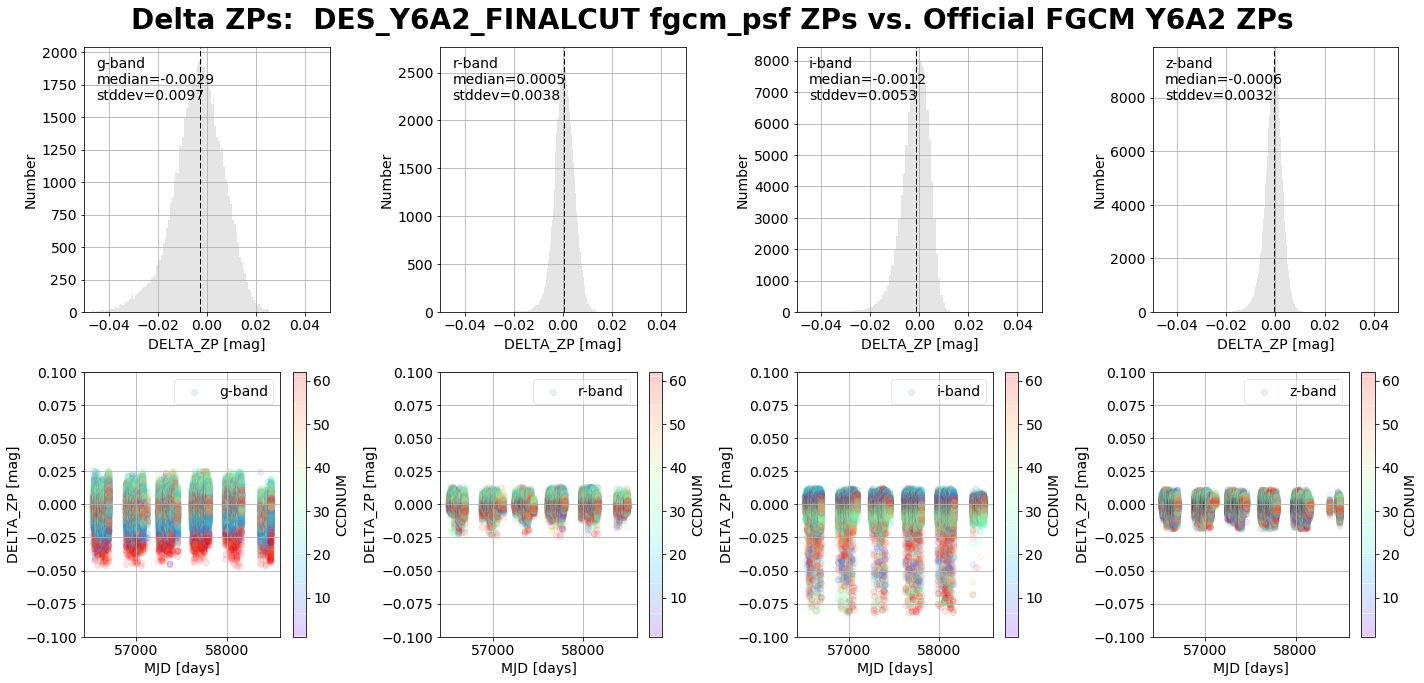

In [16]:
%%time

if do_qa_zp_xchecks:
    
    zptype = 'fgcm_psf'
    
    subdir = """DES_%s""" % (tag_des)
    df_zp_collection = df_zp_collection_des

    # Create name for output file...
    outputFileName = """%s.%s.xcheck.%s.png""" % (qaFileBaseName, subdir, zptype)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    supertitle = """Delta ZPs:  %s %s ZPs vs. Official FGCM Y6A2 ZPs""" % (subdir, zptype)
    
    status = xcheckQAPlots(df_zp_collection, df_zp_des_y6a2, bandList, supertitle, outputFileName)

**DECADE:**

In [17]:
%%time

# Read in Zeropoint Tables (FGCM PSF)
if do_qa_zp_xchecks:
    zptype = 'fgcm_psf'
    subdir = """%s""" % (tag_decade)
    df_zp_collection_decade = readZPFiles(subdir, zptype, bandList)

CPU times: user 1.2 s, sys: 92.4 ms, total: 1.3 s
Wall time: 1.29 s


In [18]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_decade['g']
df_zp.head(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT,MAG_ZERO_MEAN_SCALED
0,1.35,1,3.1061,743018,130.0,D00743018_g_c01_r5542p01_red-fullcat.fits,31.6781,0.0031,78,58244.073,149.8090,26.393242
1,1.35,2,3.1059,743018,130.0,D00743018_g_c02_r5542p01_red-fullcat.fits,31.6757,0.0029,73,58244.073,150.1198,26.390842
2,1.35,3,3.1060,743018,130.0,D00743018_g_c03_r5542p01_red-fullcat.fits,31.6899,0.0025,108,58244.073,150.4309,26.405042
3,1.35,4,2.9419,743018,130.0,D00743018_g_c04_r5542p01_red-fullcat.fits,31.6953,0.0041,92,58244.073,149.6535,26.410442
4,1.35,5,2.9424,743018,130.0,D00743018_g_c05_r5542p01_red-fullcat.fits,31.6906,0.0034,88,58244.073,149.9644,26.405742


../QA/qaPlot.ZPs.DECADE_FINALCUT.xcheck.fgcm_psf.png
CPU times: user 30 s, sys: 7.93 s, total: 37.9 s
Wall time: 37.9 s


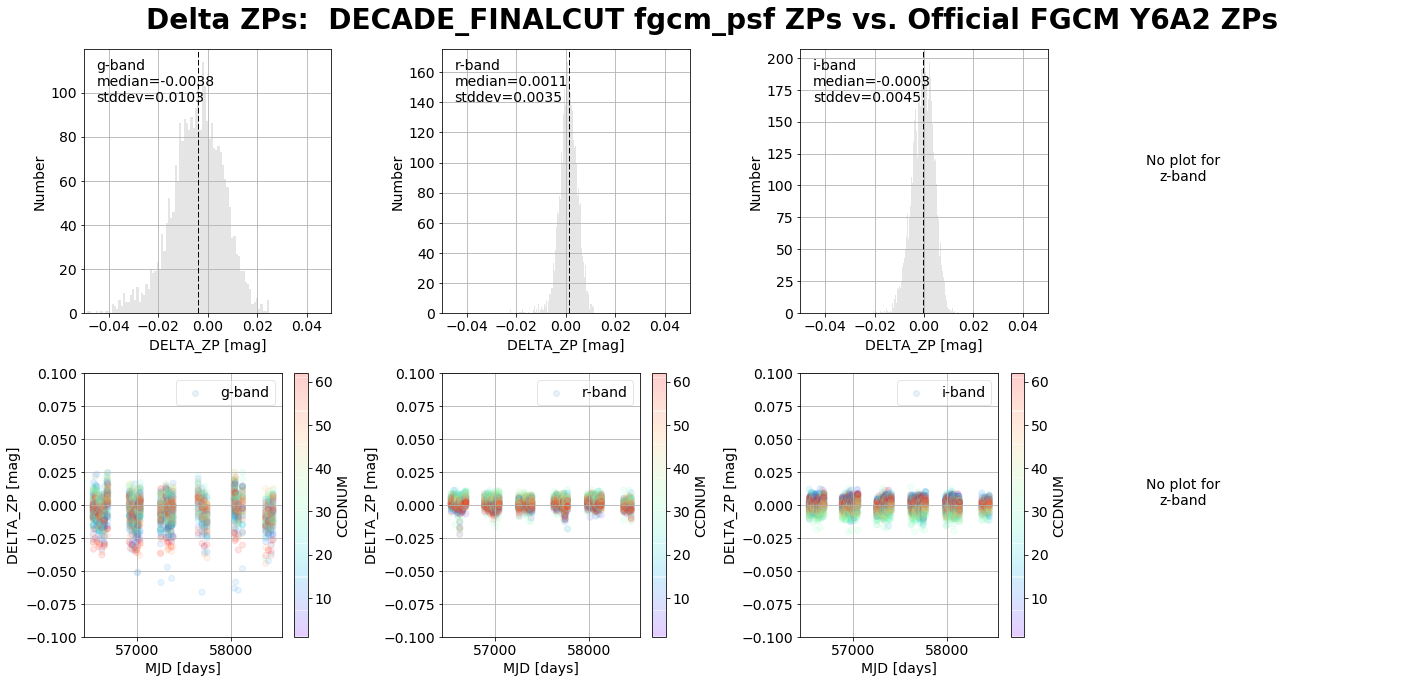

In [19]:
%%time

if do_qa_zp_xchecks:
    
    zptype = 'fgcm_psf'
    
    subdir = """%s""" % (tag_decade)
    df_zp_collection = df_zp_collection_decade

    # Create name for output file...
    outputFileName = """%s.%s.xcheck.%s.png""" % (qaFileBaseName, subdir, zptype)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    supertitle = """Delta ZPs:  %s %s ZPs vs. Official FGCM Y6A2 ZPs""" % (subdir, zptype)
    
    status = xcheckQAPlots(df_zp_collection, df_zp_des_y6a2, bandList, supertitle, outputFileName)

## 6.  Create Some QA plots for the Zeropoint Tables (FGCM Aper8)

**We will first work with the DES data, and then we will repeat for the DECADE data.**

**DES:**

In [20]:
%%time

# Read in Zeropoint Tables (FGCM Aper8)
if do_qa_zp_xchecks:
    zptype = 'fgcm_aper8'
    subdir = """DES_%s""" % (tag_des)
    df_zp_collection_des = readZPFiles(subdir, zptype, bandList)

CPU times: user 5.61 s, sys: 206 ms, total: 5.81 s
Wall time: 5.79 s


In [21]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_des['g']
df_zp.head(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT,MAG_ZERO_MEAN_SCALED
0,1.18,1,1.8057,573106,90.0,D00573106_g_c01_r3624p01_red-fullcat.fits,31.5014,0.0072,101,57641.3113,36.9081,26.615794
1,1.18,3,1.8055,573106,90.0,D00573106_g_c03_r3624p01_red-fullcat.fits,31.5086,0.0070,104,57641.3113,37.5294,26.622994
2,1.18,4,1.6416,573106,90.0,D00573106_g_c04_r3624p01_red-fullcat.fits,31.5179,0.0053,100,57641.3113,36.7526,26.632294
3,1.18,5,1.6420,573106,90.0,D00573106_g_c05_r3624p01_red-fullcat.fits,31.5009,0.0063,97,57641.3113,37.0633,26.615294
4,1.18,6,1.6418,573106,90.0,D00573106_g_c06_r3624p01_red-fullcat.fits,31.5250,0.0066,112,57641.3113,37.3741,26.639394


../QA/qaPlot.ZPs.DES_Y6A2_FINALCUT.xcheck.fgcm_aper8.png
CPU times: user 54.4 s, sys: 4.9 s, total: 59.3 s
Wall time: 59.3 s


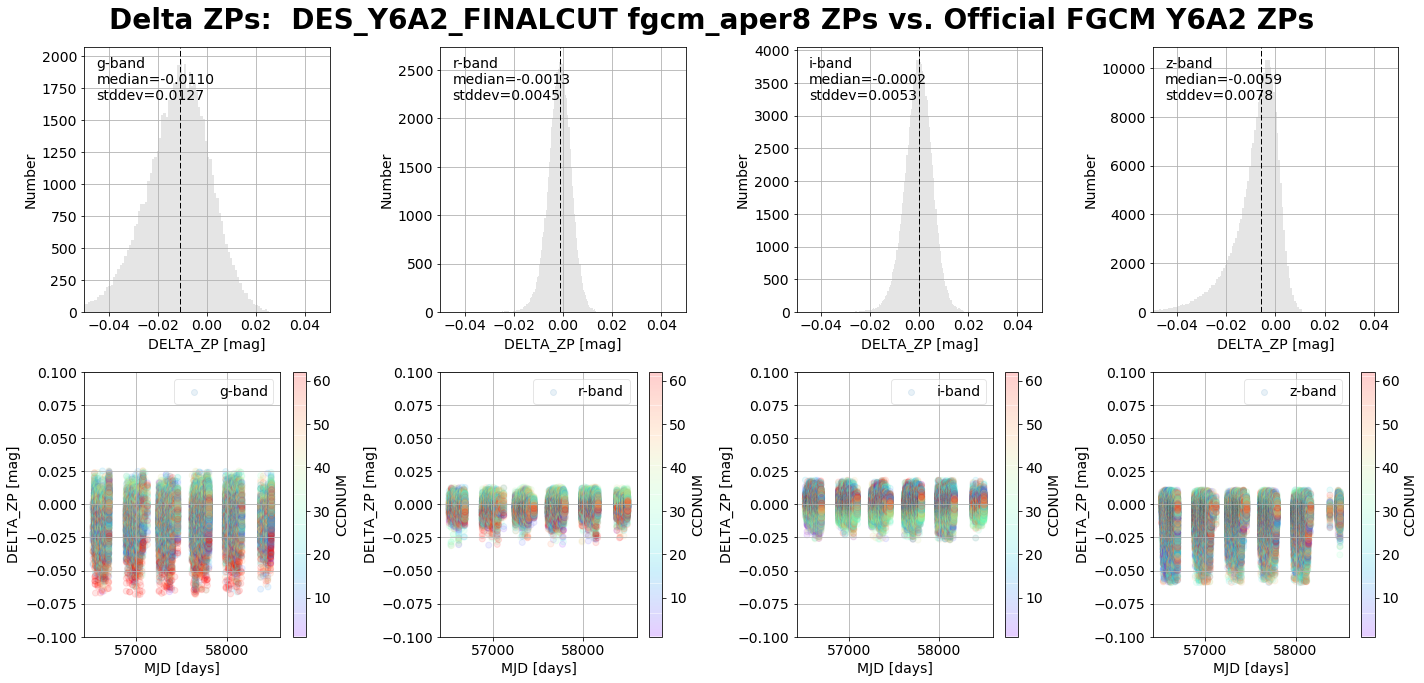

In [22]:
%%time

if do_qa_zp_xchecks:
    
    zptype = 'fgcm_aper8'
    
    subdir = """DES_%s""" % (tag_des)
    df_zp_collection = df_zp_collection_des

    # Create name for output file...
    outputFileName = """%s.%s.xcheck.%s.png""" % (qaFileBaseName, subdir, zptype)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    supertitle = """Delta ZPs:  %s %s ZPs vs. Official FGCM Y6A2 ZPs""" % (subdir, zptype)
    
    status = xcheckQAPlots(df_zp_collection, df_zp_des_y6a2, bandList, supertitle, outputFileName)

**DECADE:**

In [23]:
%%time

# Read in Zeropoint Tables (FGCM Aper8)
if do_qa_zp_xchecks:
    zptype = 'fgcm_aper8'
    subdir = """%s""" % (tag_decade)
    df_zp_collection_decade = readZPFiles(subdir, zptype, bandList)

CPU times: user 1.24 s, sys: 56 ms, total: 1.29 s
Wall time: 1.29 s


In [24]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_decade['g']
df_zp.head(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT,MAG_ZERO_MEAN_SCALED
0,1.35,1,3.1061,743018,130.0,D00743018_g_c01_r5542p01_red-fullcat.fits,31.6830,0.0041,79,58244.073,149.8090,26.398142
1,1.35,2,3.1059,743018,130.0,D00743018_g_c02_r5542p01_red-fullcat.fits,31.6807,0.0071,76,58244.073,150.1198,26.395842
2,1.35,3,3.1060,743018,130.0,D00743018_g_c03_r5542p01_red-fullcat.fits,31.6921,0.0044,111,58244.073,150.4309,26.407242
3,1.35,4,2.9419,743018,130.0,D00743018_g_c04_r5542p01_red-fullcat.fits,31.6983,0.0078,93,58244.073,149.6535,26.413442
4,1.35,5,2.9424,743018,130.0,D00743018_g_c05_r5542p01_red-fullcat.fits,31.6929,0.0070,88,58244.073,149.9644,26.408042


../QA/qaPlot.ZPs.DECADE_FINALCUT.xcheck.fgcm_aper8.png
CPU times: user 30.6 s, sys: 11.9 s, total: 42.5 s
Wall time: 42.6 s


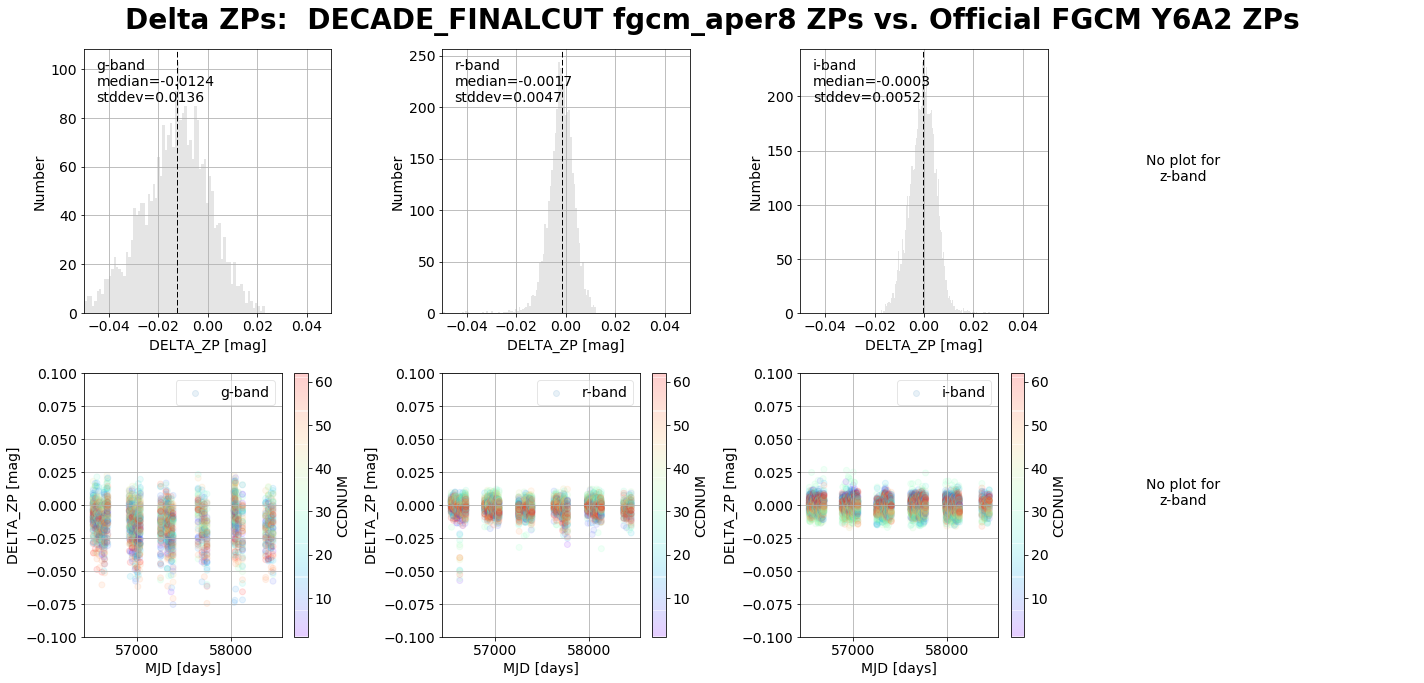

In [25]:
%%time

if do_qa_zp_xchecks:
    
    zptype = 'fgcm_aper8'
    
    subdir = """%s""" % (tag_decade)
    df_zp_collection = df_zp_collection_decade

    # Create name for output file...
    outputFileName = """%s.%s.xcheck.%s.png""" % (qaFileBaseName, subdir, zptype)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    supertitle = """Delta ZPs:  %s %s ZPs vs. Official FGCM Y6A2 ZPs""" % (subdir, zptype)
    
    status = xcheckQAPlots(df_zp_collection, df_zp_des_y6a2, bandList, supertitle, outputFileName)

## 7.  Create Some QA plots for the Zeropoint Tables (REFCAT2)¶

**We will first work with the DES data, and then we will repeat for the DECADE data.**

**DES:**

In [26]:
%%time

# Read in Zeropoint Tables (REFCAT2)
if do_qa_zp_xchecks:
    zptype = 'refcat2'
    subdir = """DES_%s""" % (tag_des)
    df_zp_collection_des = readZPFiles(subdir, zptype, bandList)

CPU times: user 6.72 s, sys: 494 ms, total: 7.22 s
Wall time: 7.46 s


In [27]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_des['g']
df_zp.head(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT,MAG_ZERO_MEAN_SCALED
0,1.18,1,1.8057,573106,90.0,D00573106_g_c01_r3624p01_red-fullcat.fits,31.4880,0.0048,34,57641.3113,36.9081,26.602394
1,1.18,3,1.8055,573106,90.0,D00573106_g_c03_r3624p01_red-fullcat.fits,31.4986,0.0034,37,57641.3113,37.5294,26.612994
2,1.18,4,1.6416,573106,90.0,D00573106_g_c04_r3624p01_red-fullcat.fits,31.4953,0.0048,37,57641.3113,36.7526,26.609694
3,1.18,5,1.6420,573106,90.0,D00573106_g_c05_r3624p01_red-fullcat.fits,31.4898,0.0065,37,57641.3113,37.0633,26.604194
4,1.18,6,1.6418,573106,90.0,D00573106_g_c06_r3624p01_red-fullcat.fits,31.4931,0.0051,43,57641.3113,37.3741,26.607494


../QA/qaPlot.ZPs.DES_Y6A2_FINALCUT.xcheck.refcat2.png
CPU times: user 54 s, sys: 5.41 s, total: 59.4 s
Wall time: 59.4 s


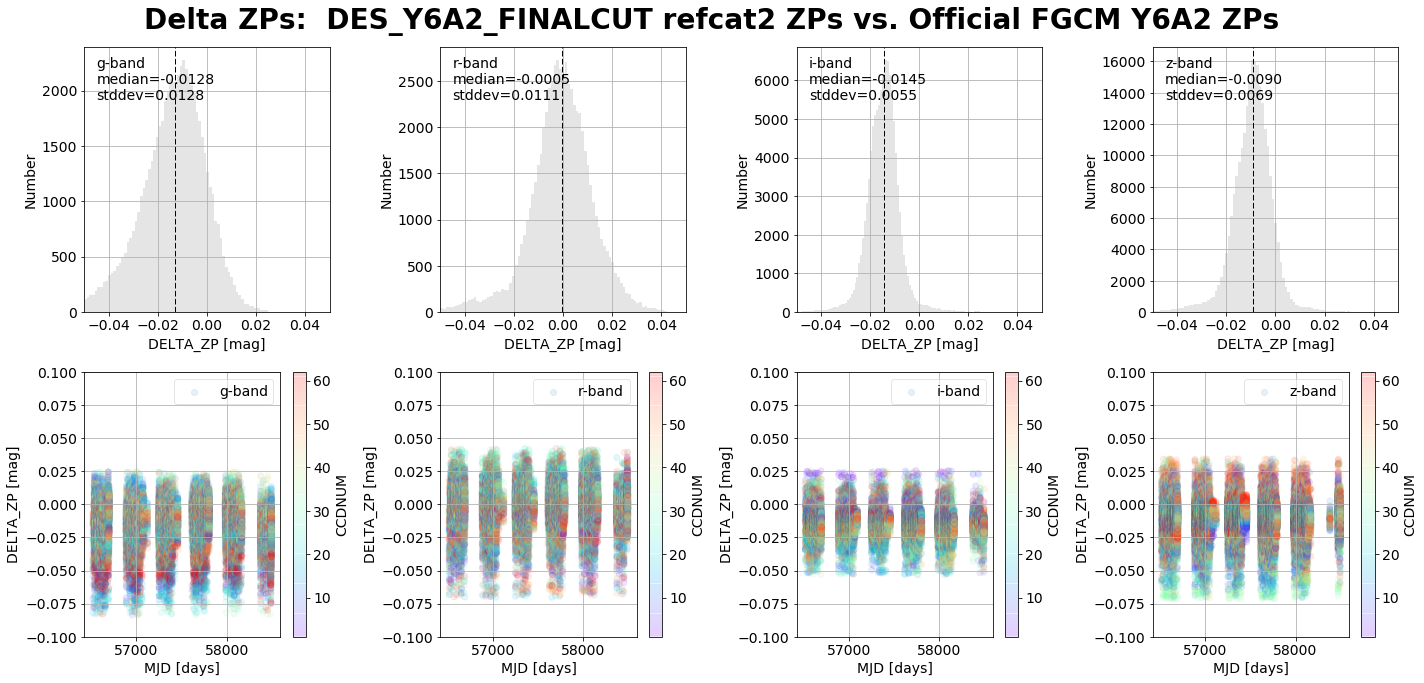

In [28]:
%%time

if do_qa_zp_xchecks:
    
    zptype = 'refcat2'
    
    subdir = """DES_%s""" % (tag_des)
    df_zp_collection = df_zp_collection_des

    # Create name for output file...
    outputFileName = """%s.%s.xcheck.%s.png""" % (qaFileBaseName, subdir, zptype)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    supertitle = """Delta ZPs:  %s %s ZPs vs. Official FGCM Y6A2 ZPs""" % (subdir, zptype)
    
    status = xcheckQAPlots(df_zp_collection, df_zp_des_y6a2, bandList, supertitle, outputFileName)

**DECADE:**

In [29]:
%%time

# Read in Zeropoint Tables (REFCAT2)
if do_qa_zp_xchecks:
    zptype = 'refcat2'
    subdir = """%s""" % (tag_decade)
    df_zp_collection_decade = readZPFiles(subdir, zptype, bandList)

CPU times: user 1.42 s, sys: 64.3 ms, total: 1.48 s
Wall time: 1.47 s


In [30]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_decade['g']
df_zp.head(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT,MAG_ZERO_MEAN_SCALED
0,1.35,1,3.1061,743018,130.0,D00743018_g_c01_r5542p01_red-fullcat.fits,31.6835,0.0053,37,58244.073,149.8090,26.398642
1,1.35,2,3.1059,743018,130.0,D00743018_g_c02_r5542p01_red-fullcat.fits,31.6786,0.0060,29,58244.073,150.1198,26.393742
2,1.35,3,3.1060,743018,130.0,D00743018_g_c03_r5542p01_red-fullcat.fits,31.6895,0.0040,58,58244.073,150.4309,26.404642
3,1.35,4,2.9419,743018,130.0,D00743018_g_c04_r5542p01_red-fullcat.fits,31.6862,0.0084,37,58244.073,149.6535,26.401342
4,1.35,5,2.9424,743018,130.0,D00743018_g_c05_r5542p01_red-fullcat.fits,31.6883,0.0038,39,58244.073,149.9644,26.403442


../QA/qaPlot.ZPs.DECADE_FINALCUT.xcheck.refcat2.png
CPU times: user 28.3 s, sys: 8.98 s, total: 37.3 s
Wall time: 37.4 s


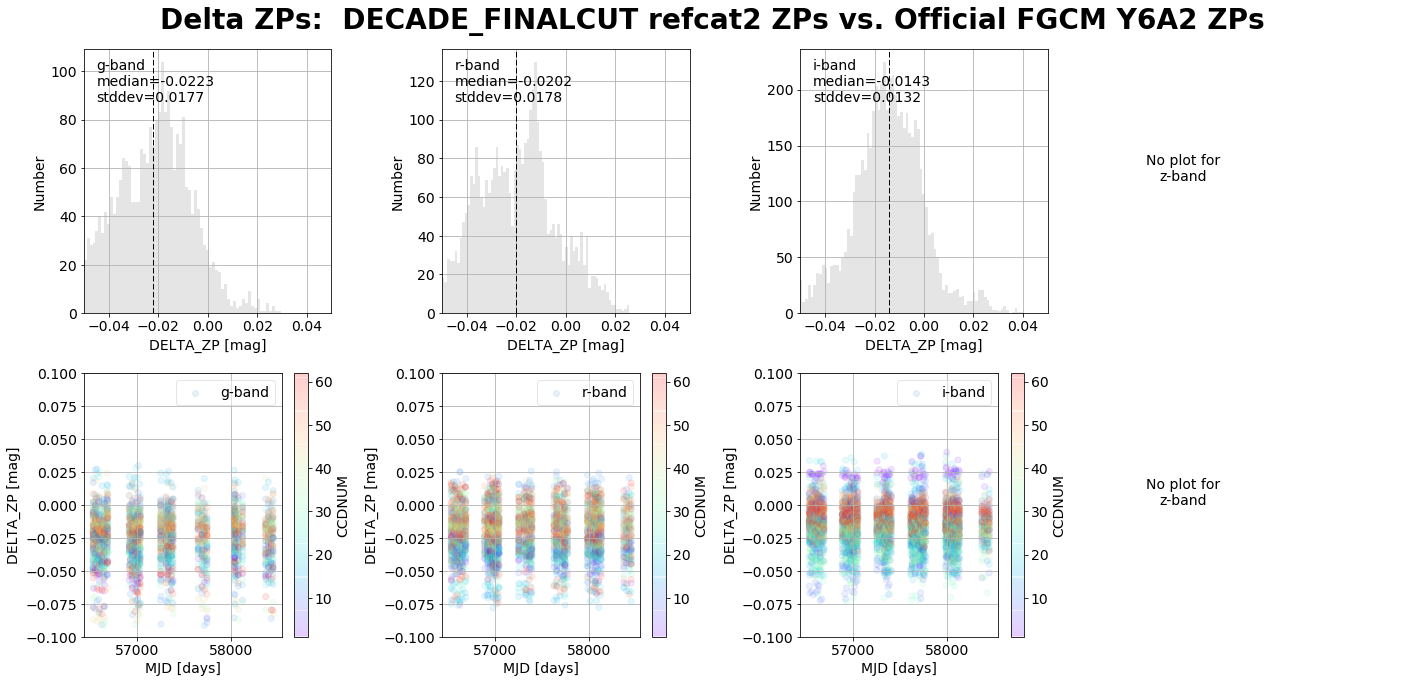

In [31]:
%%time

if do_qa_zp_xchecks:
    
    zptype = 'refcat2'
    
    subdir = """%s""" % (tag_decade)
    df_zp_collection = df_zp_collection_decade

    # Create name for output file...
    outputFileName = """%s.%s.xcheck.%s.png""" % (qaFileBaseName, subdir, zptype)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    supertitle = """Delta ZPs:  %s %s ZPs vs. Official FGCM Y6A2 ZPs""" % (subdir, zptype)
    
    status = xcheckQAPlots(df_zp_collection, df_zp_des_y6a2, bandList, supertitle, outputFileName)

## 8.  Create Some QA plots for the Zeropoint Tables (SDSS)¶

**We will first work with the DES data, and then we will repeat for the DECADE data.**

**DES:**

In [32]:
%%time

# Read in Zeropoint Tables (SDSS)
if do_qa_zp_xchecks:
    zptype = 'sdss'
    subdir = """DES_%s""" % (tag_des)
    df_zp_collection_des = readZPFiles(subdir, zptype, bandList)

CPU times: user 2.83 s, sys: 165 ms, total: 2.99 s
Wall time: 3.15 s


In [33]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_des['g']
df_zp.head(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT,MAG_ZERO_MEAN_SCALED
0,1.18,1,1.8057,573106,90.0,D00573106_g_c01_r3624p01_red-fullcat.fits,31.5385,0.0034,29,57641.3113,36.9081,26.652894
1,1.18,3,1.8055,573106,90.0,D00573106_g_c03_r3624p01_red-fullcat.fits,31.5246,0.0040,58,57641.3113,37.5294,26.638994
2,1.18,4,1.6416,573106,90.0,D00573106_g_c04_r3624p01_red-fullcat.fits,31.5024,0.0051,40,57641.3113,36.7526,26.616794
3,1.18,5,1.6420,573106,90.0,D00573106_g_c05_r3624p01_red-fullcat.fits,31.5203,0.0035,39,57641.3113,37.0633,26.634694
4,1.18,6,1.6418,573106,90.0,D00573106_g_c06_r3624p01_red-fullcat.fits,31.5133,0.0066,35,57641.3113,37.3741,26.627694


../QA/qaPlot.ZPs.DES_Y6A2_FINALCUT.xcheck.sdss.png
CPU times: user 37.7 s, sys: 4.56 s, total: 42.3 s
Wall time: 42.3 s


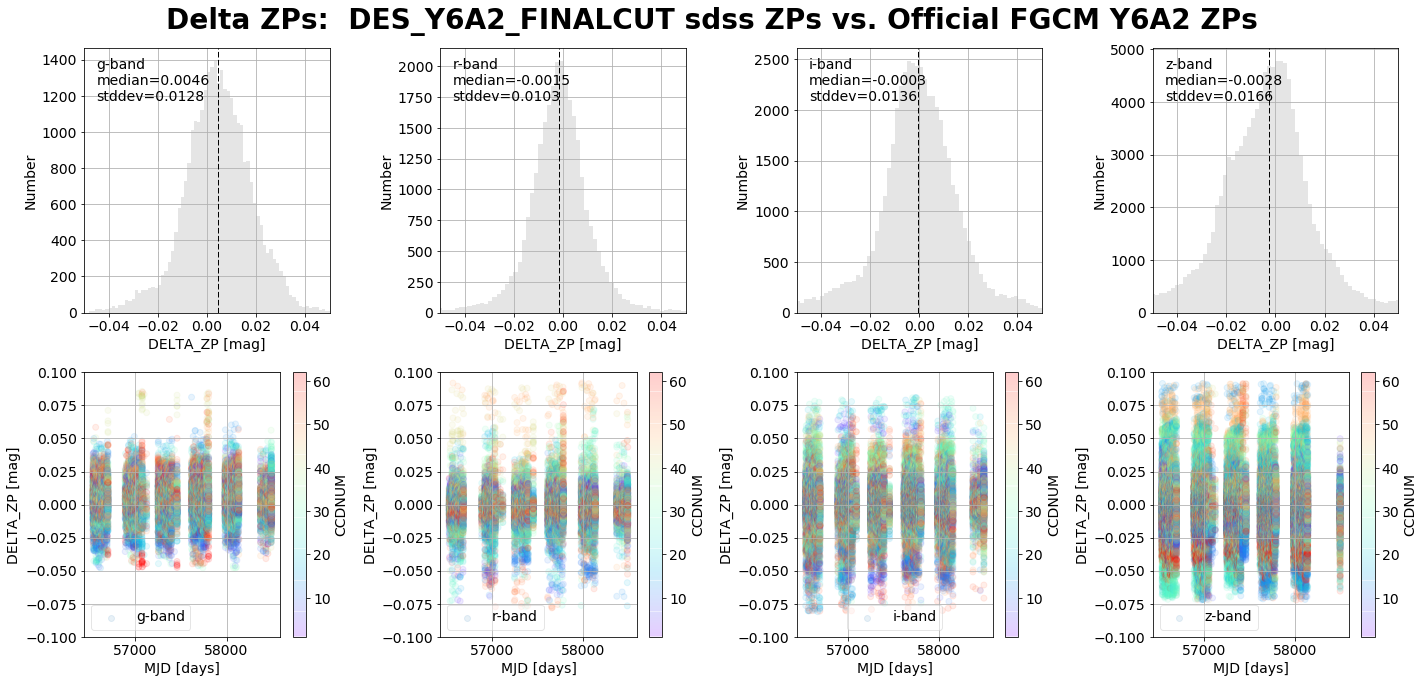

In [34]:
%%time

if do_qa_zp_xchecks:
    
    zptype = 'sdss'
    
    subdir = """DES_%s""" % (tag_des)
    df_zp_collection = df_zp_collection_des

    # Create name for output file...
    outputFileName = """%s.%s.xcheck.%s.png""" % (qaFileBaseName, subdir, zptype)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    supertitle = """Delta ZPs:  %s %s ZPs vs. Official FGCM Y6A2 ZPs""" % (subdir, zptype)
    
    status = xcheckQAPlots(df_zp_collection, df_zp_des_y6a2, bandList, supertitle, outputFileName)

**DECADE:**

In [35]:
%%time

# Read in Zeropoint Tables (SDSS)
if do_qa_zp_xchecks:
    zptype = 'sdss'
    subdir = """%s""" % (tag_decade)
    df_zp_collection_decade = readZPFiles(subdir, zptype, bandList)

CPU times: user 350 ms, sys: 34.6 ms, total: 385 ms
Wall time: 382 ms


In [36]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_decade['g']
df_zp.head(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT,MAG_ZERO_MEAN_SCALED
0,1.35,1,3.1061,743018,130.0,D00743018_g_c01_r5542p01_red-fullcat.fits,31.6955,0.0036,33,58244.073,149.8090,26.410642
1,1.35,2,3.1059,743018,130.0,D00743018_g_c02_r5542p01_red-fullcat.fits,31.6711,0.0027,36,58244.073,150.1198,26.386242
2,1.35,3,3.1060,743018,130.0,D00743018_g_c03_r5542p01_red-fullcat.fits,31.6859,0.0043,56,58244.073,150.4309,26.401042
3,1.35,4,2.9419,743018,130.0,D00743018_g_c04_r5542p01_red-fullcat.fits,31.6875,0.0037,35,58244.073,149.6535,26.402642
4,1.35,5,2.9424,743018,130.0,D00743018_g_c05_r5542p01_red-fullcat.fits,31.6912,0.0027,33,58244.073,149.9644,26.406342


../QA/qaPlot.ZPs.DECADE_FINALCUT.xcheck.sdss.png
CPU times: user 26.1 s, sys: 8.69 s, total: 34.8 s
Wall time: 34.9 s


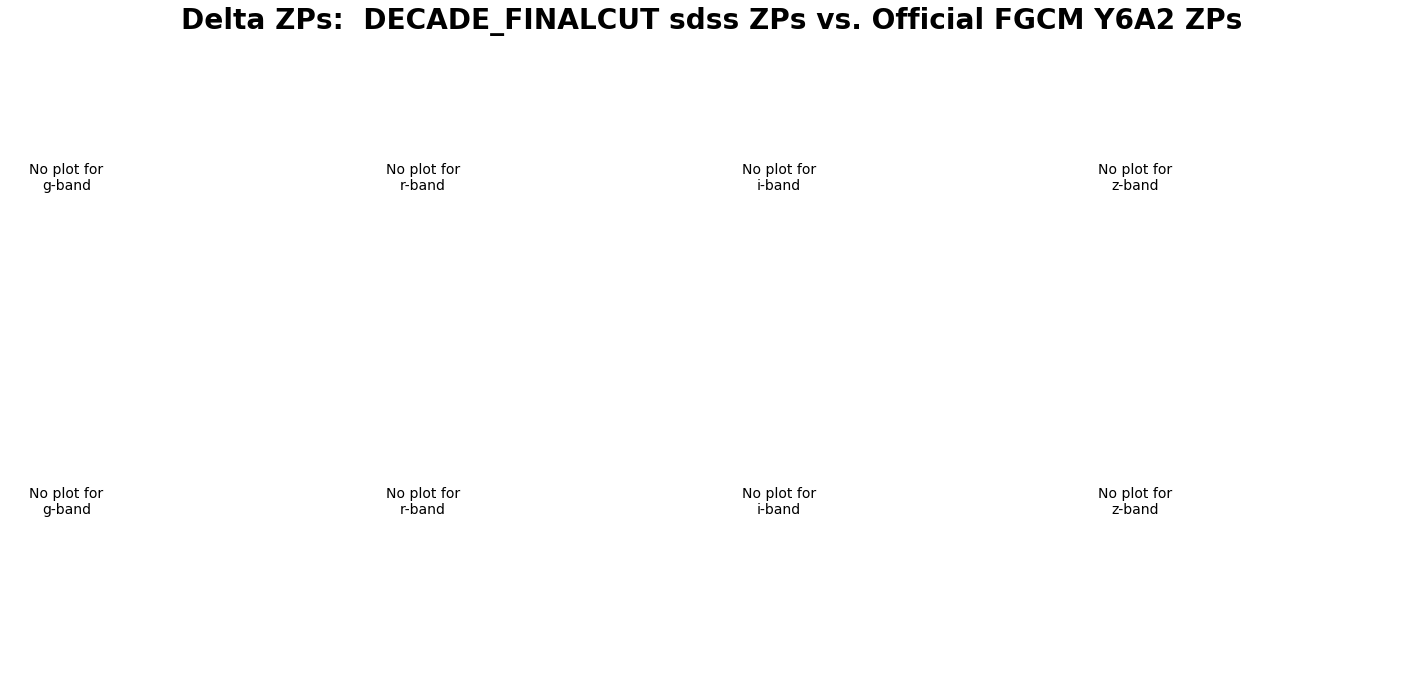

In [37]:
%%time

if do_qa_zp_xchecks:
    
    zptype = 'sdss'
    
    subdir = """%s""" % (tag_decade)
    df_zp_collection = df_zp_collection_decade

    # Create name for output file...
    outputFileName = """%s.%s.xcheck.%s.png""" % (qaFileBaseName, subdir, zptype)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    supertitle = """Delta ZPs:  %s %s ZPs vs. Official FGCM Y6A2 ZPs""" % (subdir, zptype)
    
    status = xcheckQAPlots(df_zp_collection, df_zp_des_y6a2, bandList, supertitle, outputFileName)

## 9.  Create Some QA plots Comparing u-band Zeropoints from GALEX+GaiaEDR3 and from SDSS

**We will first work with the DES data, and then we will repeat for the DECADE data.**

**DES:**

In [38]:
%%time

# Read in u-band Zeropoint Table from GALEX+GaiaEDR3
if do_qa_zp_xchecks:
    zptype = 'galex.gaiaedr3'
    subdir = """DES_%s""" % (tag_des)
    df_zp_collection = readZPFiles(subdir, zptype, ['u'])
    df_zp_galex_u = df_zp_collection['u']

CPU times: user 255 ms, sys: 32.6 ms, total: 288 ms
Wall time: 285 ms


In [39]:
# Let's look at the zeropoint table...
df_zp_galex_u.tail(5)

,FILENAME,EXPNUM,EXPTIME,AIRMASS,MJD_OBS,CCDNUM,RA_CENT,DEC_CENT,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MAG_ZERO_MEAN_SCALED
14399,D00561602_u_c57_r3624p01_red-fullcat.fits,561602,400.0,1.11,57607.4142,57,36.3128,-5.2701,30.6531,0.0239,9,24.14795
14400,D00561602_u_c58_r3624p01_red-fullcat.fits,561602,400.0,1.11,57607.4142,58,36.6250,-5.2703,30.6737,0.0256,7,24.16855
14401,D00561602_u_c59_r3624p01_red-fullcat.fits,561602,400.0,1.11,57607.4142,59,36.9368,-5.2699,30.5813,0.0272,8,24.07615
14402,D00561602_u_c60_r3624p01_red-fullcat.fits,561602,400.0,1.11,57607.4142,60,36.1570,-5.4339,30.6422,0.0407,7,24.13705
14403,D00561602_u_c62_r3624p01_red-fullcat.fits,561602,400.0,1.11,57607.4142,62,36.7809,-5.4342,30.6520,0.0181,4,24.14685


In [40]:
%%time

# Read in u-band Zeropoint Table from GALEX+GaiaEDR3
if do_qa_zp_xchecks:
    zptype = 'sdss'
    subdir = """DES_%s""" % (tag_des)
    df_zp_collection = readZPFiles(subdir, zptype, ['u'])
    df_zp_sdss_u = df_zp_collection['u']

CPU times: user 73.5 ms, sys: 3.07 ms, total: 76.6 ms
Wall time: 74.7 ms


In [41]:
# Let's look at the zeropoint table...
df_zp_sdss_u.tail(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT,MAG_ZERO_MEAN_SCALED
5946,1.11,57,-5.2701,561602,400.0,D00561602_u_c57_r3624p01_red-fullcat.fits,30.6523,0.0119,15,57607.4142,36.3128,24.14715
5947,1.11,58,-5.2703,561602,400.0,D00561602_u_c58_r3624p01_red-fullcat.fits,30.6885,0.0181,17,57607.4142,36.6250,24.18335
5948,1.11,59,-5.2699,561602,400.0,D00561602_u_c59_r3624p01_red-fullcat.fits,30.6207,0.0277,13,57607.4142,36.9368,24.11555
5949,1.11,60,-5.4339,561602,400.0,D00561602_u_c60_r3624p01_red-fullcat.fits,30.6598,0.0201,19,57607.4142,36.1570,24.15465
5950,1.11,62,-5.4342,561602,400.0,D00561602_u_c62_r3624p01_red-fullcat.fits,30.6426,0.0158,14,57607.4142,36.7809,24.13745


../QA/qaPlot.ZPs.DES_Y6A2_FINALCUT.galex_gaiaedr3_vs_sdss.u.png
count    5544.000000
mean       -0.008083
std         0.052797
min        -0.390400
0.1%       -0.347178
1%         -0.189600
25%        -0.029900
50%        -0.004500
75%         0.018100
99%         0.122771
99.9%       0.190432
max         0.218800
Name: DELTA_ZP, dtype: float64
CPU times: user 2.76 s, sys: 51.8 ms, total: 2.81 s
Wall time: 2.8 s


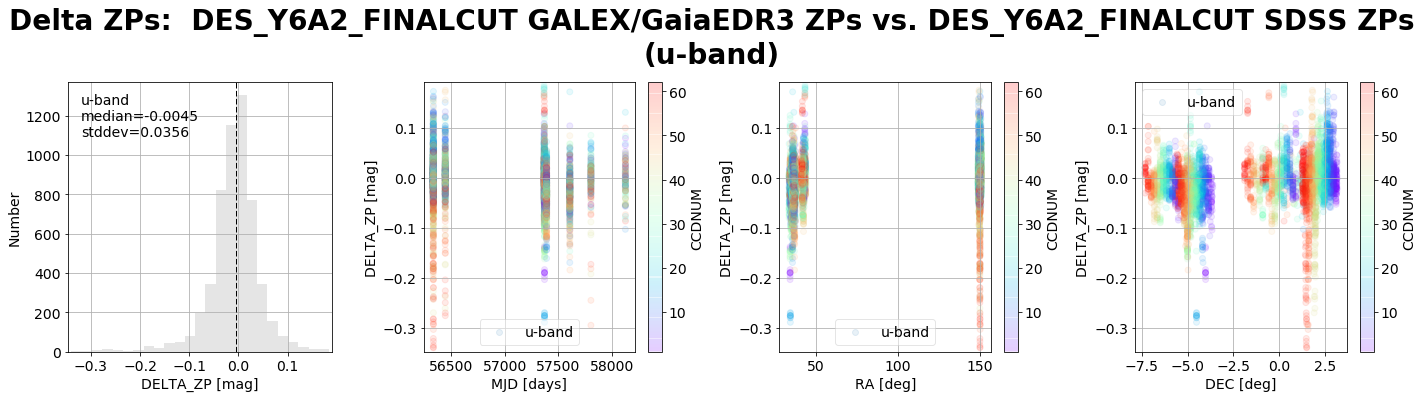

In [42]:
%%time

if do_qa_zp_xchecks:
    
    subdir = """DES_%s""" % (tag_des)

    # Create name for output file...
    outputFileName = """%s.%s.galex_gaiaedr3_vs_sdss.u.png""" % (qaFileBaseName, subdir)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    supertitle = """Delta ZPs:  %s GALEX/GaiaEDR3 ZPs vs. %s SDSS ZPs\n(u-band)""" % (subdir, subdir)

    status = galexGaiaEDR3vsSDSSuQAPlots(df_zp_galex_u, df_zp_sdss_u, supertitle, outputFileName)

**DECADE:**

In [43]:
%%time

# Read in u-band Zeropoint Table from GALEX+GaiaEDR3
if do_qa_zp_xchecks:
    zptype = 'galex.gaiaedr3'
    subdir = """%s""" % (tag_decade)
    df_zp_collection = readZPFiles(subdir, zptype, ['u'])
    df_zp_galex_u = df_zp_collection['u']

CPU times: user 49.7 ms, sys: 5.85 ms, total: 55.6 ms
Wall time: 52.5 ms


In [44]:
# Let's look at the zeropoint table...
df_zp_galex_u.tail(5)

,FILENAME,EXPNUM,EXPTIME,AIRMASS,MJD_OBS,CCDNUM,RA_CENT,DEC_CENT,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MAG_ZERO_MEAN_SCALED
2163,D00946190_u_c57_r5151p02_red-fullcat.fits,946190,300.0,1.11,59139.2167,57,36.2962,-5.3439,30.5044,0.0170,7,24.311597
2164,D00946190_u_c58_r5151p02_red-fullcat.fits,946190,300.0,1.11,59139.2167,58,36.6085,-5.3441,30.5058,0.0230,8,24.312997
2165,D00946190_u_c59_r5151p02_red-fullcat.fits,946190,300.0,1.11,59139.2167,59,36.9203,-5.3437,30.4539,0.0237,9,24.261097
2166,D00946190_u_c60_r5151p02_red-fullcat.fits,946190,300.0,1.11,59139.2167,60,36.1404,-5.5076,30.4726,0.0385,7,24.279797
2167,D00946190_u_c62_r5151p02_red-fullcat.fits,946190,300.0,1.11,59139.2167,62,36.7644,-5.5080,30.5431,NaN,1,24.350297


In [45]:
%%time

# Read in u-band Zeropoint Table from GALEX+GaiaEDR3
if do_qa_zp_xchecks:
    zptype = 'sdss'
    subdir = """%s""" % (tag_decade)
    df_zp_collection = readZPFiles(subdir, zptype, ['u'])
    df_zp_sdss_u = df_zp_collection['u']

CPU times: user 12 ms, sys: 1.13 ms, total: 13.1 ms
Wall time: 10.6 ms


In [46]:
# Let's look at the zeropoint table...
df_zp_sdss_u.tail(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT,MAG_ZERO_MEAN_SCALED
295,1.11,57,-5.3439,946190,300.0,D00946190_u_c57_r5151p02_red-fullcat.fits,30.5302,0.0110,17,59139.2167,36.2962,24.337397
296,1.11,58,-5.3441,946190,300.0,D00946190_u_c58_r5151p02_red-fullcat.fits,30.5096,0.0134,27,59139.2167,36.6085,24.316797
297,1.11,59,-5.3437,946190,300.0,D00946190_u_c59_r5151p02_red-fullcat.fits,30.5017,0.0195,13,59139.2167,36.9203,24.308897
298,1.11,60,-5.5076,946190,300.0,D00946190_u_c60_r5151p02_red-fullcat.fits,30.4707,0.0252,19,59139.2167,36.1404,24.277897
299,1.11,62,-5.5080,946190,300.0,D00946190_u_c62_r5151p02_red-fullcat.fits,30.4820,0.0145,5,59139.2167,36.7644,24.289197


../QA/qaPlot.ZPs.DECADE_FINALCUT.galex_gaiaedr3_vs_sdss.u.png
count    255.000000
mean      -0.011185
std        0.050327
min       -0.268600
0.1%      -0.248991
1%        -0.137790
25%       -0.034400
50%       -0.010100
75%        0.007600
99%        0.125052
99.9%      0.222657
max        0.239700
Name: DELTA_ZP, dtype: float64
CPU times: user 1.3 s, sys: 20 ms, total: 1.32 s
Wall time: 1.32 s


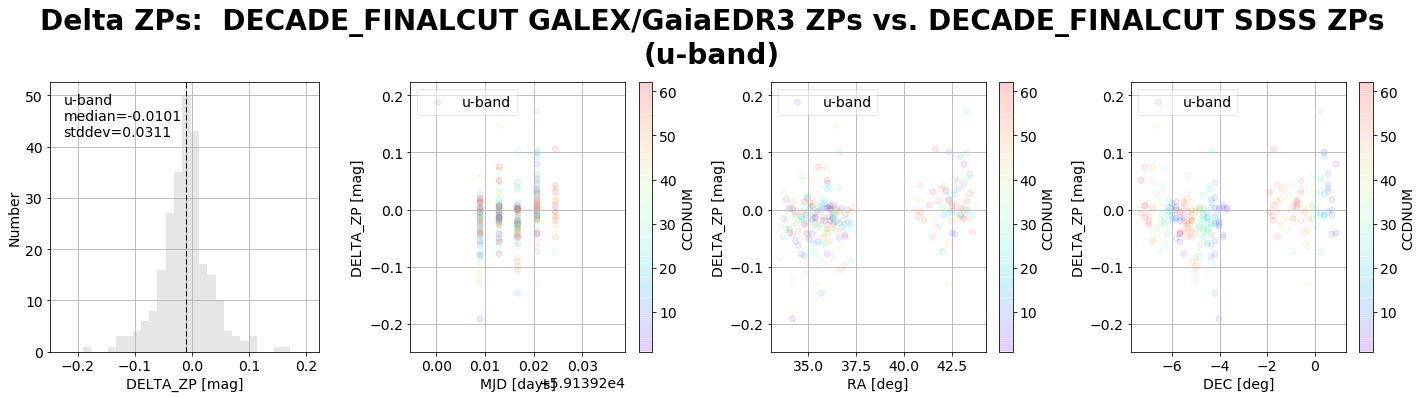

In [47]:
%%time

if do_qa_zp_xchecks:
    
    subdir = """%s""" % (tag_decade)

    # Create name for output file...
    outputFileName = """%s.%s.galex_gaiaedr3_vs_sdss.u.png""" % (qaFileBaseName, subdir)
    outputFileName = os.path.join(qa_dir, outputFileName)
    print outputFileName

    supertitle = """Delta ZPs:  %s GALEX/GaiaEDR3 ZPs vs. %s SDSS ZPs\n(u-band)""" % (subdir, subdir)

    status = galexGaiaEDR3vsSDSSuQAPlots(df_zp_galex_u, df_zp_sdss_u, supertitle, outputFileName)